In [1]:
import os

import numpy as np
import pandas as pd
import mlflow
import mlflow.sklearn
import json

DATA_DIR = "../data"

# Set tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")  

# run_id = "42c00ef221ef48538e51edbfb8ffc984"

# model = mlflow.sklearn.load_model(f"runs:/{run_id}/early_diagnosis")

logged_model = 'runs:/dfcf410e73a54c21b78745cf2c66367b/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)


C:\Users\flis1\AppData\Local\miniconda3\envs\stratifyHF\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('both', MissingIndicator(features='all'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000178B9010920>),
                                 ('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000178B96091F0>),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehot',
                                                   OneHotEncoder(drop='if_binary',
                                                 

In [3]:
feature_names = loaded_model["preprocessor"].get_feature_names_out()

In [4]:
feature_importance = (
    pd.Series(loaded_model["classifier"].feature_importances_, index=feature_names).sort_values(ascending=False)
)


In [5]:
feature_importance

num__Phy_Age                       0.374340
num__Blo_Cre                       0.173723
num__Phy_Hei                       0.127943
num__Phy_Wei                       0.109391
cat__Pat_AF_Y                      0.075530
num__Med_LD                        0.021509
cat__Phy_Sex_Male                  0.021006
cat__Pat_Hyp_Y                     0.017003
cat__Sym_DAR_Y                     0.016612
cat__Pat_DM_Y                      0.013261
cat__Pat_PMI_Y                     0.012502
both__missingindicator_Phy_Wei     0.011753
cat__Sym_CPR_Y                     0.008750
both__missingindicator_Phy_Hei     0.006937
cat__Pat_CABG_Y                    0.006077
both__missingindicator_Blo_Cre     0.003663
both__missingindicator_Pat_PMI     0.000000
both__missingindicator_Pat_AF      0.000000
both__missingindicator_Sym_CPR     0.000000
both__missingindicator_Phy_Sex     0.000000
both__missingindicator_Pat_DM      0.000000
both__missingindicator_Phy_Age     0.000000
both__missingindicator_Pat_CABG 

In [18]:
import os

target = "Dia_HFD_18M"

df = (
    pd.read_csv(os.path.join(DATA_DIR, "processed", "ED_rest_of.csv"))
      .set_index(["ID", "date"])
      .rename(columns={'Med_LD_permanent':"Med_LD"})
      .dropna(subset="Dia_HFD_18M")
)

hfpef_df = (
    pd.read_csv(os.path.join(DATA_DIR, "raw", "hfpef_confirmed_HF.csv"))
      .rename(columns={"patid": "ID"})
)
hfref_df = (
    pd.read_csv(os.path.join(DATA_DIR, "raw", "hfref_confirmed_HF.csv"))
      .rename(columns={"patid": "ID"})
)

test_df = pd.read_csv(
    os.path.join(DATA_DIR, "processed", "hosp_ed.csv"), index_col=[0, 1]
)
test_df[['Med_LD', 'Phy_Wei', 'Pat_CABG']] = pd.DataFrame(columns=('Med_LD', 'Phy_Wei', 'Pat_CABG'))


X_test = test_df.loc[:, test_df.columns.intersection(loaded_model.feature_names_in_)]
y_test = df[target]

In [19]:
test_df.loc[11304109621610, ["days_to_HFD", "Phy_Age"]]

,days_to_HFD,Phy_Age
date,,
2001-12-31,6771,62.041096
2005-09-30,5402,65.791781
2006-11-30,4976,66.958904
2008-02-29,4520,68.208219
2016-08-31,1414,76.717808
2017-09-30,1019,77.800000
2019-01-31,531,79.136986
2019-07-31,350,79.632877
2020-05-31,45,80.468493


In [20]:
y_proba = loaded_model.predict_proba(X_test.loc[11304109621610])[:, 1]

In [21]:
print(y_proba)

[0.19 0.2  0.03 0.4  0.52 0.66 0.59 0.59 0.97]


In [ ]:
cmp_df = y_test.to_frame().assign(y_proba=y_proba)
fp_df = cmp_df.loc[cmp_df["Dia_HFD_18M"].eq(0) & cmp_df["y_proba"].eq(1)]

fn_df = cmp_df.loc[cmp_df["Dia_HFD_18M"].eq(1) & cmp_df["y_proba"].lt(0.2)]

In [ ]:
pd.concat([cmp_df, df["Phy_Age"]], axis=1).to_csv(os.path.join(DATA_DIR, "results", "ED_rest_of.csv"))

In [ ]:
df.loc[fp_df.index, "Blo_NT"].describe()

In [22]:
imputer = loaded_model['preprocessor']

test_examples_df = test_df

imputed_test_examples_df = pd.DataFrame(imputer.transform(test_examples_df), columns=imputer.get_feature_names_out(), index=test_examples_df.index)

In [23]:
import shap

explainer = shap.TreeExplainer(loaded_model["classifier"])

shap_values = explainer(imputed_test_examples_df)


In [26]:
imputed_test_examples_df

both__missingindicator_Pat_Hyp  \
patid          date                                         
46533220088    2000-07-31                             0.0   
               2000-09-30                             0.0   
               2005-03-31                             0.0   
               2006-03-31                             0.0   
               2009-02-28                             0.0   
               2018-09-30                             0.0   
               2018-12-31                             0.0   
               2020-11-30                             0.0   
               2021-01-31                             0.0   
               2021-08-31                             0.0   
940700620508   2015-05-31                             0.0   
               2015-07-31                             0.0   
               2018-05-31                             0.0   
5578750421318  2018-12-31                             0.0   
6300686721514  1999-06-30                             0.0   
               1999-11-30                             0.0   
               2005-05-31                             0.0   
               2018-03-31                             0.0   
               2021-06-30                             0.0   
11304109621610 2001-12-31                             0.0   
               2005-09-30                             0.0   
               2006-11-30                             0.0   
               2008-02-29                             0.0   
               2016-08-31                             0.0   
               2017-09-30                             0.0   
               2019-01-31                             0.0   
               2019-07-31                             0.0   
               2020-05-31                             0.0   

                           both__missingindicator_Pat_CABG  \
patid          date                                          
46533220088    2000-07-31                              1.0   
               2000-09-30                              1.0   
               2005-03-31                              1.0   
               2006-03-31                              1.0   
               2009-02-28                              1.0   
               2018-09-30                              1.0   
               2018-12-31                              1.0   
               2020-11-30                              1.0   
               2021-01-31                              1.0   
               2021-08-31                              1.0   
940700620508   2015-05-31                              1.0   
               2015-07-31                              1.0   
               2018-05-31                              1.0   
5578750421318  2018-12-31                              1.0   
6300686721514  1999-06-30                              1.0   
               1999-11-30                              1.0   
               2005-05-31                              1.0   
               2018-03-31                              1.0   
               2021-06-30                              1.0   
11304109621610 2001-12-31                              1.0   
               2005-09-30                              1.0   
               2006-11-30                              1.0   
               2008-02-29                              1.0   
               2016-08-31                              1.0   
               2017-09-30                              1.0   
               2019-01-31                              1.0   
               2019-07-31                              1.0   
               2020-05-31                              1.0   

                           both__missingindicator_Pat_PMI  \
patid          date                                         
46533220088    2000-07-31                             0.0   
               2000-09-30                             0.0   
               2005-03-31                             0.0   
               2006-03-31     

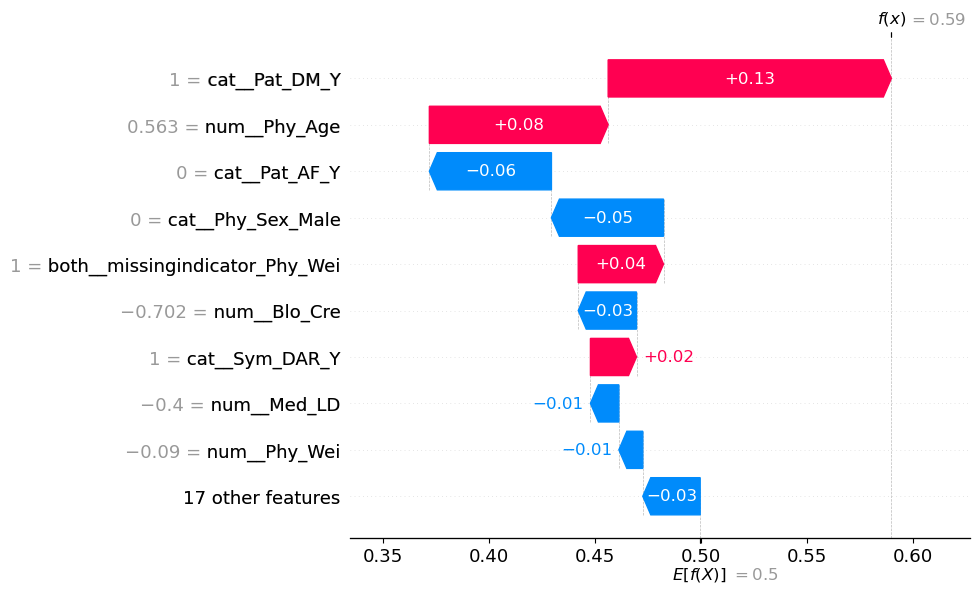

In [30]:
shap.plots.waterfall(shap_values[-2,:, 1])


In [ ]:
shap.plots.bar(shap_values[:, :, 1])

In [ ]:
shap_summary = np.mean(np.abs(shap_values.values), axis=(0, 1))

In [ ]:
shap_importances = pd.Series(np.mean(np.abs(shap_values.values[:, :, 1]), axis=0), index=feature_names)

In [ ]:
shap_importances.sort_values(ascending=False).to_csv(os.path.join(DATA_DIR, "stats", "shap_feature_importance.csv"))

In [ ]:
from __future__ import annotations

import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
)

def binary_metrics_by_age_cohort(
    y_test,
    y_proba,
    age,
    *,
    start_age: int = 40,
    end_age: int = 100,
    cohort_size: int = 10,
    threshold: float = 0.5,
    positive_label: int = 1,
) -> pd.DataFrame:
    """
    Compute binary classification metrics stratified by 10-year age cohorts.

    Cohorts are half-open bins like [40,50), [50,60), ..., [100,110).
    Includes ages within [start_age, end_age] (inclusive).

    Parameters
    ----------
    y_test : array-like of shape (n_samples,)
        True labels (binary).
    y_proba : array-like of shape (n_samples,)
        Predicted probability for the positive class.
    age : array-like of shape (n_samples,)
        Age for each example.
    start_age, end_age : int
        Inclusive age range to evaluate (default 40..100 inclusive).
    cohort_size : int
        Size of cohort bins (default 10).
    threshold : float
        Decision threshold for converting probabilities to class predictions.
    positive_label : int
        The label considered "positive" (default 1).

    Returns
    -------
    pd.DataFrame
        One row per cohort with metrics and counts.
    """
    y_test = np.asarray(y_test)
    y_proba = np.asarray(y_proba, dtype=float)
    age = np.asarray(age, dtype=float)

    if not (len(y_test) == len(y_proba) == len(age)):
        raise ValueError("y_test, y_proba, and age must have the same length.")

    # Filter to requested age range (inclusive)
    mask = (age >= start_age) & (age <= end_age) & np.isfinite(age)
    y_test_f = y_test[mask]
    y_proba_f = y_proba[mask]
    age_f = age[mask].astype(int)

    if y_test_f.size == 0:
        # Return empty but well-formed output
        cols = [
            "cohort", "age_min", "age_max", "n", "n_pos", "n_neg",
            "prevalence", "roc_auc", "pr_auc", "log_loss", "brier",
            "accuracy", "balanced_accuracy", "precision", "recall", "f1",
            "specificity", "tn", "fp", "fn", "tp",
        ]
        return pd.DataFrame(columns=cols)

    # Define bins: [40,50),...,[100,110) so that age=100 is included
    edges = np.arange(start_age, end_age + cohort_size + 1, cohort_size)  # 40..110 step 10
    cohort_labels = [f"{lo}-{lo+cohort_size-1}" for lo in edges[:-1]]
    cohorts = pd.cut(
        age_f,
        bins=edges,
        right=False,              # left-closed, right-open
        labels=cohort_labels,
        include_lowest=True,
    )

    y_pred_f = (y_proba_f >= threshold).astype(int)
    # Map positives if labels are not {0,1}
    # We assume y_test is already binary; if not, user should encode beforehand.
    if positive_label != 1:
        # Convert to {0,1} for sklearn metrics that assume positive_label=1 by default
        y_test_bin = (y_test_f == positive_label).astype(int)
    else:
        y_test_bin = y_test_f.astype(int)

    rows = []
    for label in cohort_labels:
        idx = (cohorts == label).to_numpy()
        if idx.sum() == 0:
            # Keep cohorts with no samples (optional); here we include with NaNs.
            lo = int(label.split("-")[0])
            hi = int(label.split("-")[1])
            rows.append({
                "cohort": label, "age_min": lo, "age_max": hi,
                "n": 0, "n_pos": 0, "n_neg": 0, "prevalence": np.nan,
                "roc_auc": np.nan, "pr_auc": np.nan, "log_loss": np.nan, "brier": np.nan,
                "accuracy": np.nan, "balanced_accuracy": np.nan, "precision": np.nan,
                "recall": np.nan, "f1": np.nan, "specificity": np.nan,
                "tn": np.nan, "fp": np.nan, "fn": np.nan, "tp": np.nan,
            })
            continue

        yt = y_test_bin[idx]
        yp = y_proba_f[idx]
        yhat = y_pred_f[idx]

        n = int(yt.size)
        n_pos = int((yt == 1).sum())
        n_neg = int((yt == 0).sum())
        prev = n_pos / n if n else np.nan

        # Confusion matrix with fixed label order to guarantee 2x2
        tn, fp, fn, tp = confusion_matrix(yt, yhat, labels=[0, 1]).ravel()

        # Some metrics require both classes present; handle gracefully
        roc_auc = roc_auc_score(yt, yp) if (n_pos > 0 and n_neg > 0) else np.nan
        pr_auc = average_precision_score(yt, yp) if (n_pos > 0 and n_neg > 0) else np.nan

        # log_loss requires both classes unless labels are provided
        ll = log_loss(yt, yp, labels=[0, 1])
        brier = brier_score_loss(yt, yp)

        acc = accuracy_score(yt, yhat)
        bacc = balanced_accuracy_score(yt, yhat)
        prec = precision_score(yt, yhat, zero_division=0)
        rec = recall_score(yt, yhat, zero_division=0)
        f1 = f1_score(yt, yhat, zero_division=0)

        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        lo = int(label.split("-")[0])
        hi = int(label.split("-")[1])

        rows.append({
            "cohort": label,
            "age_min": lo,
            "age_max": hi,
            "n": n,
            "n_pos": n_pos,
            "n_neg": n_neg,
            "prevalence": prev,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
            "log_loss": ll,
            "brier": brier,
            "accuracy": acc,
            "balanced_accuracy": bacc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "specificity": spec,
            "tn": int(tn),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
        })

    return pd.DataFrame(rows)


In [ ]:
binary_metrics_by_age_cohort(y_test, y_proba, df["Phy_Age"])